# Определение перспективного тарифа для телеком-компании

**Заказчик** 

Комерческий департамент федерального оператора сотовой связи «Мегалайн».


**Цель проекта**

Предварительный анализ  поведения клиентов, пользующихся тарифными планами "Смарт" и "Ультра". 

Необходимо определить, какой тариф прибыльнее с точки зрения компании. Информация будет учтена при корректировке рекламного бюджета. Для ответа на этот вопрос будут проверены две гипотезы:

1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


**Входные данные**

Данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Файлы `users`, `tariffs`, `calls`, `internet` и `messeges`. 


**Описание тарифов**

*Тариф «Смарт»*

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
 - минута разговора: 3 рубля
 - сообщение: 3 рубля
 - 1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
 - минута разговора: 1 рубль
 - сообщение: 1 рубль
 - 1 Гб интернет-трафика: 150 рублей

*Примечание:*

*«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*


**Ход исследования**

Исследование пройдёт в пять этапов:

*    Обзор данных;
*    Предобработка данных;
*    Расчеты;
*    Анализ данных;
*    Проверка гипотез.

## Обзор данных

In [1]:
# импорт библиотек
from scipy import stats as st
from math import factorial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# чтение файла с данными и сохранение в df
calls = pd.read_csv('calls.csv')
messages = pd.read_csv('messages.csv')
internet = pd.read_csv('internet.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [3]:
# обзор датафрейма tariff
tariffs.info()
display(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В таблице восемь столбцов:

- `messages_included` - количество включенных в тарифный пакет СМС
- `mb_per_month_included` - количество включенных в тарифный пакет Гб интернет-трафика
- `minutes_included` - количество включенных в тарифный пакет минут
- `rub_monthly_fee` - абоненская плата
- `rub_per_gb` - стоимость 1 Гб интернет-трафика сверх тарифного пакета
- `rub_per_message` - стоимость 1 СМС сверх тарифного пакета
- `rub_per_minute` - стоимость 1 минуты сверх тарифного пакета
- `tariff_name` - наименование тарифа

In [4]:
# функция для первичного ознакомления с остальными датафреймами
def data_info(data):
    data.info()
    display(data.sample(7))

In [5]:
data_info(calls)    # обзор датафрейма calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
42506,1104_408,2018-04-01,7.24,1104
138146,1352_870,2018-08-22,16.46,1352
96862,1247_185,2018-06-17,0.97,1247
86031,1216_138,2018-12-11,0.00,1216
36227,1090_51,2018-10-13,3.32,1090
39290,1098_118,2018-09-09,0.00,1098
62888,1158_446,2018-03-05,4.23,1158


В таблице четыре столбца:

- `id` - идентификатор звонка
- `call_date` - дата звонка
- `duration` - продолжительность разговора (в минутах)
- `user_id` - уникальный идентификатор пользователя

In [6]:
data_info(messages)    # обзор датафрейма messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
86321,1357_114,2018-11-24,1357
109866,1441_31,2018-12-26,1441
71813,1302_641,2018-11-22,1302
46112,1200_7,2018-05-04,1200
44634,1196_84,2018-11-24,1196
12621,1054_177,2018-11-23,1054
62989,1274_575,2018-05-27,1274


В таблице три столбца:

- `id` - идентификатор СМС
- `message_date` - дата отправки СМС
- `user_id` - уникальный идентификатор пользователя

In [7]:
data_info(internet)    # обзор датафрейма internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
74830,74830,1251_392,263.72,2018-11-21,1251
123695,123695,1415_303,342.44,2018-10-23,1415
1549,1549,1006_180,593.72,2018-11-19,1006
80285,80285,1269_297,148.23,2018-11-22,1269
127445,127445,1427_264,418.29,2018-05-21,1427
85719,85719,1291_275,508.14,2018-02-18,1291
45931,45931,1157_443,483.76,2018-07-03,1157


В таблице пять столбцов:

- `id` - идентифиткатор интернет-сессии
- `Unnamed: 0` - старые индексы таблицы
- `mb_used` - количество интернет-трафика сессии ( в Мб)
- `session_date` - дата интернет-сессии
- `user_id` - уникальный идентификатор пользователя

In [8]:
data_info(users)    # обзор датафрейма users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
456,1456,40,NaN,Санкт-Петербург,Мануэла,Андропова,2018-08-25,smart
174,1174,29,NaN,Санкт-Петербург,Лолита,Розанова,2018-02-17,smart
429,1429,54,NaN,Санкт-Петербург,Джулия,Белякова,2018-01-26,smart
276,1276,30,NaN,Москва,Михаил,Крюков,2018-10-05,ultra
312,1312,21,NaN,Санкт-Петербург,Тамара,Поликарпова,2018-07-29,smart
414,1414,70,NaN,Владимир,Александра,Лобанова,2018-05-05,smart
29,1029,51,NaN,Екатеринбург,Алексей,Селезнев,2018-09-15,smart


В таблице восемь столбцов:

- `user_id` - уникальный идентификатор пользователя
- `age` - возраст пользователя
- `reg_date` - дата заключения договора
- `churn_date` - дата расторжения договора
- `city` - город проживания пользовтеля
- `first_name` - имя пользователя
- `last_name` - фамилия пользователя
- `tariff` - тарифный план

**Выводы**

Мы ознакомились со всеми таблицами. Заметно, что тип данных в столбцах не всегда корректный (например, дата с типом `object`), есть столбцы, одинаковые по смыслу, но с разными названиями (`tariff`  и `tariff_name`). Так же нужно проверить данные на наличие дубликатов (например, что таблица с пользователями их не содержит, и `user_id` -  действительно уникальный идентификатор). Хорошо, что в данных нет пропусков (кроме информации о дате окончания действия договора с Оператором).


Так же необходимо сгруппировать данные помесячно, перевести интернет-трафик в Гб, а секунды - в минуты, округлив значения согласно примечанию выше.

Приступаем к предобработке данных.

## Предобработка данных

In [9]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024    # переводим Мб в Гб

tariffs = tariffs.rename(columns={'tariff_name': 'tariff',
                                 'mb_per_month_included' : 'gb_per_month_included'})
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


Столбцы `call_date`, `message_date`, `session_date`,`reg_date` и `churn_date` имееют тип данных `object`, поэтому меняем его на `datetime64`.

In [10]:
def data_type(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

In [11]:
data_type(calls, 'call_date')
data_type(messages, 'message_date')
data_type(internet, 'session_date')
data_type(users, 'reg_date')
data_type(users, 'churn_date')

Выделяем отдельную колонку с месяцем звонка, СМС и интернет-сесcий в датафреймах.

In [12]:
calls['call_month'] = calls['call_date'].dt.month
messages['message_month'] = messages['message_date'].dt.month
internet['session_month'] = internet['session_date'].dt.month
users['reg_date'] = users['reg_date'].dt.month
users['churn_date'] = users['churn_date'].dt.month

*Про месяц: закладываемся на тот факт, что по заданию выборка была за один год. Если бы информация содержала данные за несколько лет, мы бы воспользовались переводом в datetime (метод astype('datetime64[M]'). Он приводит дату к формату первое число - месяц – год.*

## Расчеты

###  * calls, calls_pivot

В данных мы находим звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки.


Согласно Примечанию, Оператор округляет каждый звонок до минут в бОльшую сторону.

In [13]:
calls['duration'] = np.ceil(calls['duration'])    # округляем каждый звонок в большую сторону

In [14]:
calls_pivot = calls.pivot_table(
    index = 'user_id', 
    columns = 'call_month', 
    values = 'duration',
    aggfunc = 'sum',
    fill_value = 0).reset_index().rename_axis(None, axis=1) 

calls_pivot.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
487,1495,0,0,0,0,0,0,0,92,813,1030,954,1031
488,1496,48,594,557,521,484,555,582,527,486,450,662,518
489,1497,0,0,0,0,0,0,0,0,0,490,371,545
490,1498,0,0,0,0,0,0,175,400,471,247,0,0
491,1499,0,0,0,0,0,0,0,0,70,449,612,492


Так же отдельным фреймом сделаем еще одну сводную таблицу - по количеству звонков.

In [15]:
calls_count_pivot = calls.pivot_table(
    index = 'user_id', 
    columns = 'call_month', 
    values = 'duration',
    aggfunc = 'count',
    fill_value = 0).reset_index().rename_axis(None, axis=1)

calls_count_pivot.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
487,1495,0,0,0,0,0,0,0,17,112,152,129,155
488,1496,7,77,79,67,63,74,73,88,68,72,80,80
489,1497,0,0,0,0,0,0,0,0,0,66,64,71
490,1498,0,0,0,0,0,0,23,57,59,41,0,0
491,1499,0,0,0,0,0,0,0,0,9,68,74,69


### * messages, messages_pivot

In [16]:
messages_pivot = messages.pivot_table(
    index = 'user_id', 
    columns = 'message_month', 
    values = 'id',
    aggfunc = 'count',
    fill_value = 0).reset_index().rename_axis(None, axis=1)

messages_pivot.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
421,1495,0,0,0,0,0,0,0,13,82,82,79,84
422,1496,9,45,46,49,40,35,42,41,29,35,46,51
423,1497,0,0,0,0,0,0,0,0,0,20,14,17
424,1498,0,0,0,0,0,0,20,62,44,42,0,0
425,1499,0,0,0,0,0,0,0,0,11,48,59,66


### * internet, internet_pivot

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Сделаем сводную таблицу по месяцам, а затем округлим значение интернет-трафика в бо́льшую сторону.

In [17]:
internet_pivot = internet.pivot_table(
    index = 'user_id', 
    columns = 'session_month', 
    values = 'mb_used',
    aggfunc = 'sum',
    fill_value = 0).reset_index().rename_axis(None, axis=1)

for i in range(1, 13):
    internet_pivot[i] /= 1024
    internet_pivot[i] = np.ceil(internet_pivot[i])
    
internet_pivot.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12
492,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,33.0,29.0,39.0,23.0
493,1496,4.0,28.0,25.0,21.0,24.0,20.0,24.0,23.0,27.0,28.0,25.0,21.0
494,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,14.0,20.0
495,1498,0.0,0.0,0.0,0.0,0.0,0.0,8.0,24.0,22.0,21.0,0.0,0.0
496,1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,18.0,18.0,13.0


### * users

Проверим, что в датафрейме нет явных дубликатов.

In [18]:
users.duplicated().sum()

0

Подсчитаем, сколько пользователей у каждого из тарифов:

In [19]:
users.groupby('tariff')['tariff'].count()

tariff
smart    351
ultra    149
Name: tariff, dtype: int64

### * помесячная выручка

Сделаем отдельную таблицу `users_dict`, которая будет содержать только id пользователей и их тарифный план и объединим ее с таблицей `tariffs`.

In [20]:
users_dict = users[['user_id','tariff', 'reg_date', 'churn_date']]
users_dict['churn_date'] = users_dict['churn_date'].fillna(12).astype('int')

users_tariffs_dict = users_dict.merge(tariffs, on='tariff', how='left')
users_tariffs_dict.tail(3)

,user_id,tariff,reg_date,churn_date,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
497,1497,smart,10,12,50,15.0,500,550,200,3,3
498,1498,smart,7,10,50,15.0,500,550,200,3,3
499,1499,smart,9,12,50,15.0,500,550,200,3,3


Далее, объединим новую таблицу со сводами по звонкам, сообщениям и интернет-трафику, пропуски заменим нулями. Посчитаем, сколько платных услуг было оказано в их разрезе по месяцам: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; также, прибавим абонентскую плату, соответствующую тарифному плану, к одной из таблиц).

In [21]:
calls_data = calls_pivot.merge(users_tariffs_dict, on='user_id', how='right').fillna(0)
calls_data.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,...,tariff,reg_date,churn_date,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
495,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,813.0,...,ultra,8,12,1000,30.0,3000,1950,150,1,1
496,1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,...,smart,1,12,50,15.0,500,550,200,3,3
497,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,smart,10,12,50,15.0,500,550,200,3,3
498,1498,0.0,0.0,0.0,0.0,0.0,0.0,175.0,400.0,471.0,...,smart,7,10,50,15.0,500,550,200,3,3
499,1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,...,smart,9,12,50,15.0,500,550,200,3,3


In [22]:
for i in range(1, 13):
    calls_data[i] -= calls_data['minutes_included']
    calls_data.loc[calls_data[i] < 0, i] = 0
    calls_data[i] *= calls_data['rub_per_minute']

# добавляем абонентскую плату    
for i in range(1, 13):
    for j in range(0, len(calls_data)):
        if i >= calls_data.iloc[j,14] and i <= calls_data.iloc[j,15]:
            calls_data.iloc[j,i] += calls_data.iloc[j, 19]
    
calls_data.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,...,tariff,reg_date,churn_date,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
495,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,...,ultra,8,12,1000,30.0,3000,1950,150,1,1
496,1496,550.0,832.0,721.0,613.0,550.0,715.0,796.0,631.0,550.0,...,smart,1,12,50,15.0,500,550,200,3,3
497,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,smart,10,12,50,15.0,500,550,200,3,3
498,1498,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,550.0,...,smart,7,10,50,15.0,500,550,200,3,3
499,1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,...,smart,9,12,50,15.0,500,550,200,3,3


In [23]:
calls_data[1].sum()    # проверка: общая сумма за звонки + абонентская плата

36403.0

In [24]:
calls_data = calls_data.drop(columns = ['messages_included', 'gb_per_month_included', 'minutes_included', 'rub_monthly_fee',
                             'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'reg_date', 'churn_date'], axis=1)
calls_data.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
495,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,ultra
496,1496,550.0,832.0,721.0,613.0,550.0,715.0,796.0,631.0,550.0,550.0,1036.0,604.0,smart
497,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,685.0,smart
498,1498,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,550.0,550.0,0.0,0.0,smart
499,1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,886.0,550.0,smart


In [25]:
messages_data = messages_pivot.merge(users_tariffs_dict, on='user_id', how='right').fillna(0)
messages_data.tail(3)

,user_id,1,2,3,4,5,6,7,8,9,...,tariff,reg_date,churn_date,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
497,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,smart,10,12,50,15.0,500,550,200,3,3
498,1498,0.0,0.0,0.0,0.0,0.0,0.0,20.0,62.0,44.0,...,smart,7,10,50,15.0,500,550,200,3,3
499,1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,...,smart,9,12,50,15.0,500,550,200,3,3


In [26]:
for i in range(1, 13):
    messages_data[i] -= messages_data['messages_included']
    messages_data.loc[messages_data[i] < 0, i] = 0
    messages_data[i] *= messages_data['rub_per_message'] 

messages_data = messages_data.drop(columns = ['messages_included', 'gb_per_month_included', 'minutes_included', 'rub_monthly_fee',
                             'rub_per_gb', 'rub_per_message', 'rub_per_minute','reg_date', 'churn_date'], axis=1)
messages_data.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
495,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
496,1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,smart
497,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart
498,1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,smart
499,1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,48.0,smart


In [27]:
messages_data[1].sum()    # проверка: общая сумма за СМС

72.0

In [28]:
internet_data = internet_pivot.merge(users_tariffs_dict, on='user_id', how='right').fillna(0)
internet_data.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,...,tariff,reg_date,churn_date,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
495,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,33.0,...,ultra,8,12,1000,30.0,3000,1950,150,1,1
496,1496,4.0,28.0,25.0,21.0,24.0,20.0,24.0,23.0,27.0,...,smart,1,12,50,15.0,500,550,200,3,3
497,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,smart,10,12,50,15.0,500,550,200,3,3
498,1498,0.0,0.0,0.0,0.0,0.0,0.0,8.0,24.0,22.0,...,smart,7,10,50,15.0,500,550,200,3,3
499,1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,smart,9,12,50,15.0,500,550,200,3,3


In [29]:
for i in range(1, 13):
    internet_data[i] -= internet_data['gb_per_month_included']
    internet_data.loc[internet_data[i] < 0, i] = 0
    internet_data[i] *= internet_data['rub_per_gb']

internet_data= internet_data.drop(columns = ['messages_included', 'gb_per_month_included', 'minutes_included', 'rub_monthly_fee',
                             'rub_per_gb', 'rub_per_message', 'rub_per_minute','reg_date', 'churn_date'], axis=1)
internet_data.tail(5)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
495,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,450.0,0.0,1350.0,0.0,ultra
496,1496,0.0,2600.0,2000.0,1200.0,1800.0,1000.0,1800.0,1600.0,2400.0,2600.0,2000.0,1200.0,smart
497,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,smart
498,1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1800.0,1400.0,1200.0,0.0,0.0,smart
499,1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,600.0,0.0,smart


In [30]:
internet_data[1].sum()    # проверка: общая сумма за интернет-трафик

5600.0

Теперь у нас есть три таблицы с платными услугами:
 - calls_data
 - messages_data
 - internet_data
 
Осталось объединить их в одну и сгруппировать данные по id пользователя и тарифу.

In [31]:
df_money = pd.concat([calls_data, messages_data, internet_data], join='outer').reset_index(drop=True)

df_money = df_money.groupby(['tariff','user_id'], as_index=False).sum()

df_money.tail(5)

,tariff,user_id,1,2,3,4,5,6,7,8,9,10,11,12
495,ultra,1476,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
496,ultra,1485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
497,ultra,1491,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
498,ultra,1493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,3750.0
499,ultra,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2400.0,1950.0,3300.0,1950.0


In [32]:
df_money[1].sum()    # проверка: общая сумма столбца совпадает с суммой проверок выше

42075.0

In [33]:
df_money[1].count()    # проверка: итоговое кол-во пользователей совпадает

500

Так же, объединяем таблицы по звонкам, СМС и интернет-трафиком с таблицей `user_dict` и выделим в отдельные таблицы уже в разрезе тарифов.

In [34]:
df_calls = calls_pivot.merge(users_dict, on='user_id', how='right').fillna(0)    # звонки в минутах

df_calls_count = calls_count_pivot.merge(users_dict, on='user_id', how='right').fillna(0)    # кол-во звонков

df_messages = messages_pivot.merge(users_dict, on='user_id', how='right').fillna(0)    # кол-во СМС

df_internet = internet_pivot.merge(users_dict, on='user_id', how='right').fillna(0)    # интернет-трафик

In [35]:
# функция для разделения датафрейма на два по тарифу 

df_money_ultra = df_money[df_money['tariff'] == 'ultra']    # потрачено рублей
df_money_smart = df_money[df_money['tariff'] == 'smart']

df_calls_ultra = df_calls[df_calls['tariff'] == 'ultra']    # звонки в минутах
df_calls_smart = df_calls[df_calls['tariff'] == 'smart']

df_calls_count_ultra = df_calls_count[df_calls_count['tariff'] == 'ultra']    # кол-во звонков
df_calls_count_smart = df_calls_count[df_calls_count['tariff'] == 'smart']

df_messages_ultra = df_messages[df_messages['tariff'] == 'ultra']    # кол-во СМС
df_messages_smart = df_messages[df_messages['tariff'] == 'smart']

df_internet_ultra = df_internet[df_internet['tariff'] == 'ultra']    # интернет-трафик
df_internet_smart = df_internet[df_internet['tariff'] == 'smart']


## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.


In [36]:
def analytics_bar(data1, data2, title):    # функция построения графика для математического среднего 
    index = [1,2,3,4,5,6,7,8,9,10,11,12]
    data1 = data1[index].apply(np.mean)
    data2 = data2[index].apply(np.mean)
    smart = data1.values
    ultra = data2.values
    print(smart)
    print(ultra)
    df = pd.DataFrame({'smart': smart,
                   'ultra': ultra},
                 index = index)
    ax = df.plot.bar(rot=0)
    plt.grid(True) # сетка
    plt.title(title, loc = 'left')
    plt.legend(bbox_to_anchor = (1,1)) # положение легенды
    plt.show()

def analytics_hist(data1, data2, title):    # функция построения гистограммы матматического среднего
    index = [1,2,3,4,5,6,7,8,9,10,11,12]
    data1 = data1[index].apply(np.mean)
    data2 = data2[index].apply(np.mean)
    smart = data1.values
    ultra = data2.values
    print(smart)
    print(ultra)
    df = pd.DataFrame({'smart': smart,
                   'ultra': ultra},
                 index = index)
    df.plot(kind='hist', alpha=0.5, bins=10)
    plt.grid(True) # сетка
    plt.title(title, loc = 'left')
    plt.legend(bbox_to_anchor = (1,1)) # положение легенды
    plt.show()

def analytics_hist_add(data1, data2, func, title):    # функция построения гистограммы ст. отклонения и дисперсии
    index = [1,2,3,4,5,6,7,8,9,10,11,12]
    data1 = func(data1[index], ddof=1)
    data2 = func(data2[index], ddof=1)
    smart = data1.values
    ultra = data2.values
    print(smart)
    print(ultra)
    df = pd.DataFrame({'smart': smart,
                   'ultra': ultra},
                 index = index)
    df.plot(kind='hist', alpha=0.5, bins=10)
    plt.grid(True) # сетка
    plt.title(title, loc = 'left')
    plt.legend(bbox_to_anchor = (1,1)) # положение легенды
    plt.show()

### * звонки

[ 19.74643875  49.35612536  85.56695157 117.14814815 155.60683761
 184.85754986 233.84330484 282.17948718 317.49002849 356.93447293
 391.86324786 459.47293447]
[ 25.8590604   47.8590604  121.59060403 169.06711409 229.47651007
 270.43624161 333.33557047 366.79865772 416.34899329 460.69798658
 486.87919463 553.02013423]


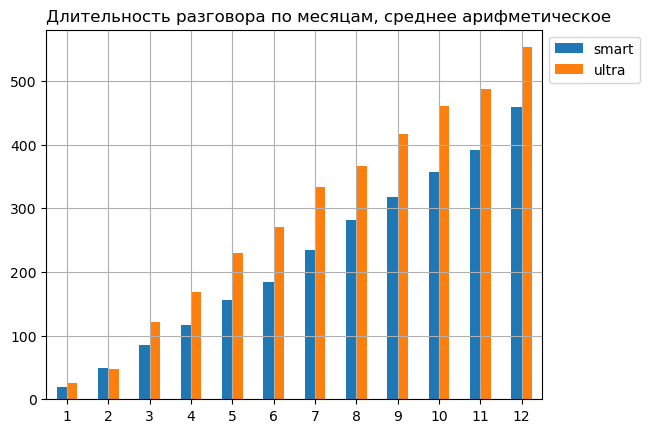

In [37]:
analytics_bar(df_calls_smart, df_calls_ultra, 'Длительность разговора по месяцам, среднее арифметическое')

[ 2.68091168  6.64102564 11.91737892 16.37321937 22.19088319 25.95441595
 32.48433048 39.48717949 44.10826211 50.22507123 55.37037037 63.83475783]
[ 3.59060403  6.69127517 16.80536913 23.65771812 32.60402685 37.62416107
 46.28187919 51.19463087 57.57718121 63.87248322 67.55704698 77.72483221]


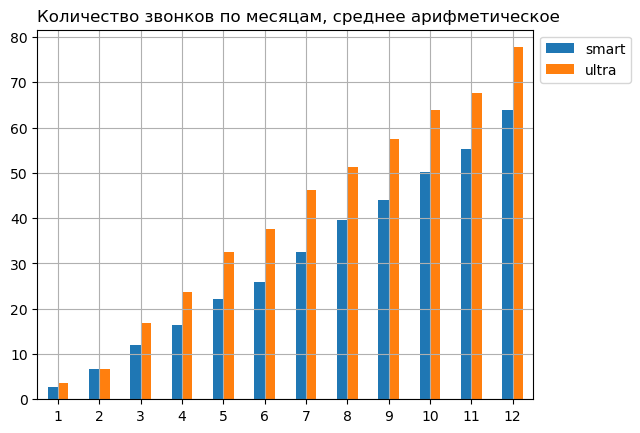

In [38]:
analytics_bar(df_calls_count_smart, df_calls_count_ultra, 'Количество звонков по месяцам, среднее арифметическое')

Мы видим уверенный рост как самого количества звонков, так и их продолжительности от месяца к месяцу. Скорее всего, это связано с ростом абонентской базы.

Средний пользователь тарифа "Ультра" звонят чаще и говорит дольше (за исключением февраля).

[ 19.74643875  49.35612536  85.56695157 117.14814815 155.60683761
 184.85754986 233.84330484 282.17948718 317.49002849 356.93447293
 391.86324786 459.47293447]
[ 25.8590604   47.8590604  121.59060403 169.06711409 229.47651007
 270.43624161 333.33557047 366.79865772 416.34899329 460.69798658
 486.87919463 553.02013423]


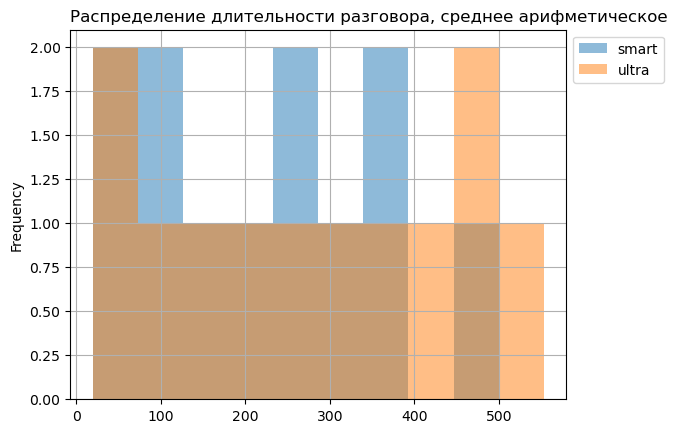

In [39]:
analytics_hist(df_calls_smart, df_calls_ultra, 'Распределение длительности разговора, среднее арифметическое')

У пользователей тарифа "Смарт" есть несколько пиков, пользователи тарифа "Ультра" говорят или мало или много.

[ 76.73748261 135.17136726 184.72730618 200.99428774 223.816224
 231.07037195 243.62532347 250.3571032  245.35061626 233.23688444
 213.31005894 216.57817785]
[120.02342227 160.22931288 268.60455243 274.45616163 319.8217321
 329.10466835 358.6860332  351.1772283  364.72872048 364.59399308
 336.89381824 362.63365606]


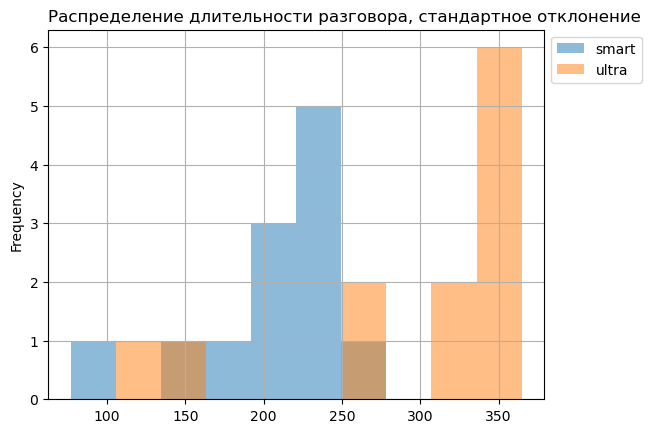

In [40]:
analytics_hist_add(df_calls_smart, df_calls_ultra, np.std, 'Распределение длительности разговора, стандартное отклонение')

Стандартное отклонение у пользователей "Ультры" больше.

[ 5888.64123728 18271.29852666 34124.17764754 40398.7037037
 50093.70212454 53393.51679284 59353.29823362 62678.67912088
 60196.92490028 54399.44426536 45501.18124542 46906.10712251]
[ 14405.62189371  25673.43270452  72148.40558679  75326.18465445
 102285.94032287 108309.88273173 128655.67041538 123325.44567386
 133027.0395429  132928.77979322 113497.44476691 131503.16851079]


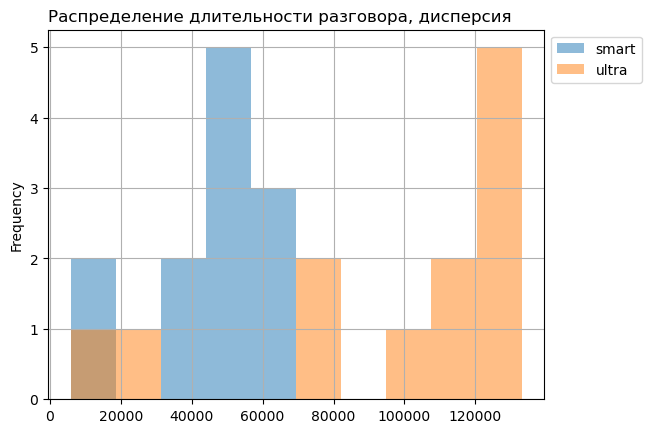

In [41]:
analytics_hist_add(df_calls_smart, df_calls_ultra, np.var, 'Распределение длительности разговора, дисперсия')

### * СМС

[ 1.76638177  3.98005698  6.98860399  9.80911681 13.56695157 15.60683761
 19.32763533 22.52136752 24.91737892 28.28205128 30.67806268 34.55840456]
[ 2.04026846  3.53691275  8.02013423 11.65100671 17.02013423 23.52348993
 30.44295302 34.7852349  40.3557047  48.23489933 50.17449664 56.54362416]


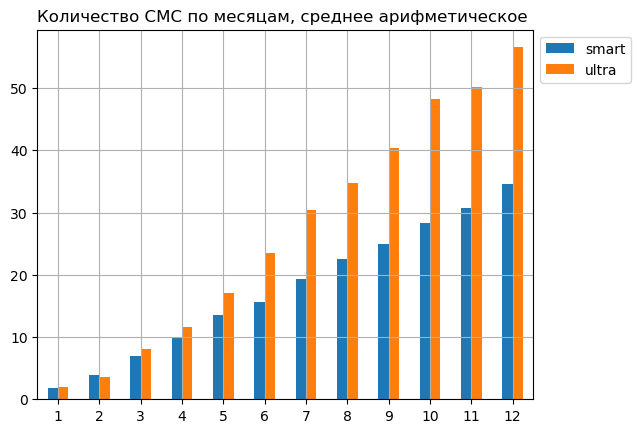

In [42]:
analytics_bar(df_messages_smart, df_messages_ultra, 'Количество СМС по месяцам, среднее арифметическое')

С количеством СМС все повторяется: уверенный рост от месяца к месяцу, пользователи "Ультры" опережают пользователей "Смарта", но только не в феврале.

[ 1.76638177  3.98005698  6.98860399  9.80911681 13.56695157 15.60683761
 19.32763533 22.52136752 24.91737892 28.28205128 30.67806268 34.55840456]
[ 2.04026846  3.53691275  8.02013423 11.65100671 17.02013423 23.52348993
 30.44295302 34.7852349  40.3557047  48.23489933 50.17449664 56.54362416]


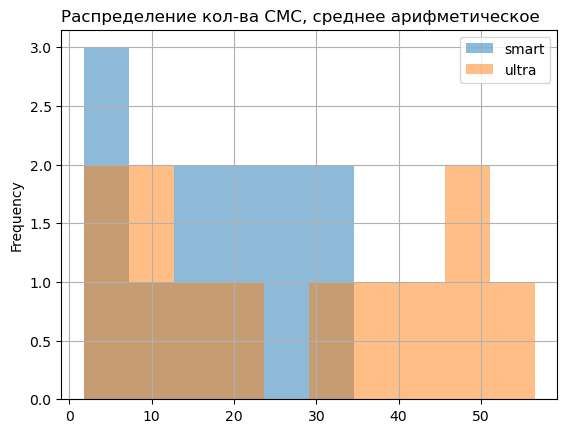

In [43]:
analytics_hist(df_messages_smart, df_messages_ultra, 'Распределение кол-ва СМС, среднее арифметическое')

В среднем, пользователи обоих тарифов пишут менее 10 СМС в месяц. При этом, пользователи "Смарта" придерживаются месячного лимита, в то время как пользователи "Ультры" даже не приближаются к нему (имея возможность отправлять по 1000 СМС бесплатно на ежемесячной основе, в самый насыщенный месяц используют всего 1/20 своих возможностей).

[ 7.34240975 12.54191378 18.17438971 19.921719   23.81837086 25.57865983
 27.14128758 28.48716953 28.3369826  28.9607161  28.80766868 30.77840396]
[10.77213572 13.30389269 24.84777161 27.33202413 32.88523652 39.30676028
 45.1346907  45.09547885 46.29285069 52.13902793 50.09608761 52.27170223]


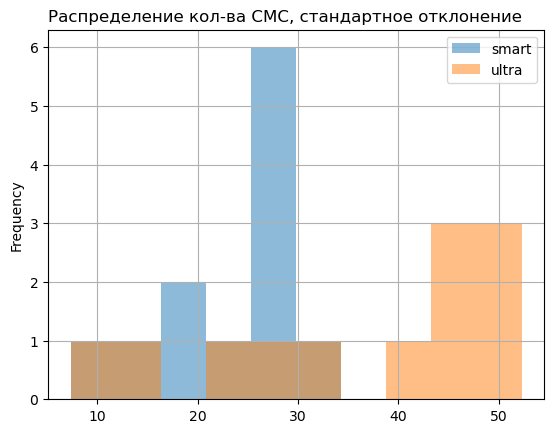

In [44]:
analytics_hist_add(df_messages_smart, df_messages_ultra, np.std, 'Распределение кол-ва СМС, стандартное отклонение')

[ 53.91098087 157.29960114 330.30844119 396.87488807 567.31479039
 654.26783883 736.64949125 811.51882784 802.98458282 838.72307692
 829.88177452 947.31015059]
[ 116.03890804  176.99356067  617.41175404  747.0395429  1081.43878106
 1545.02140395 2037.14030473 2033.60221295 2143.02802467 2718.47823327
 2509.61799383 2732.33085434]


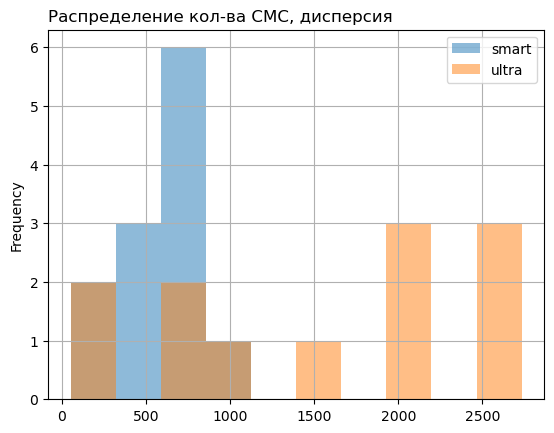

In [45]:
analytics_hist_add(df_messages_smart, df_messages_ultra, np.var, 'Распределение кол-ва СМС, дисперсия')

### * интернет-трафик

[ 0.84615385  1.95726496  3.34188034  4.34757835  6.39031339  7.45299145
  9.09116809 11.20512821 12.14245014 14.13960114 15.3048433  17.47578348]
[ 0.79865772  1.93288591  4.38255034  6.26174497  8.7114094  10.67785235
 12.52348993 14.0738255  14.85234899 16.56375839 17.81208054 20.28187919]


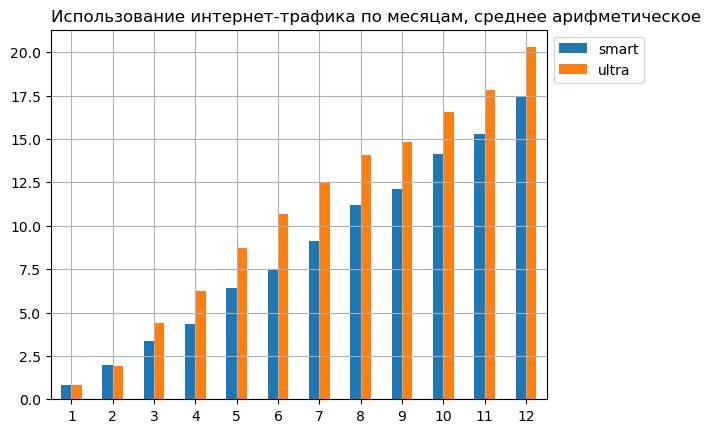

In [46]:
analytics_bar(df_internet_smart, df_internet_ultra, 'Использование интернет-трафика по месяцам, среднее арифметическое')

Тенденция роста и соотношения сохраняются. В ноябре и декабре пользователи тарифа "Смарт" превышали своей ежемесячный лимит в размере 15 Гб.

[ 0.84615385  1.95726496  3.34188034  4.34757835  6.39031339  7.45299145
  9.09116809 11.20512821 12.14245014 14.13960114 15.3048433  17.47578348]
[ 0.79865772  1.93288591  4.38255034  6.26174497  8.7114094  10.67785235
 12.52348993 14.0738255  14.85234899 16.56375839 17.81208054 20.28187919]


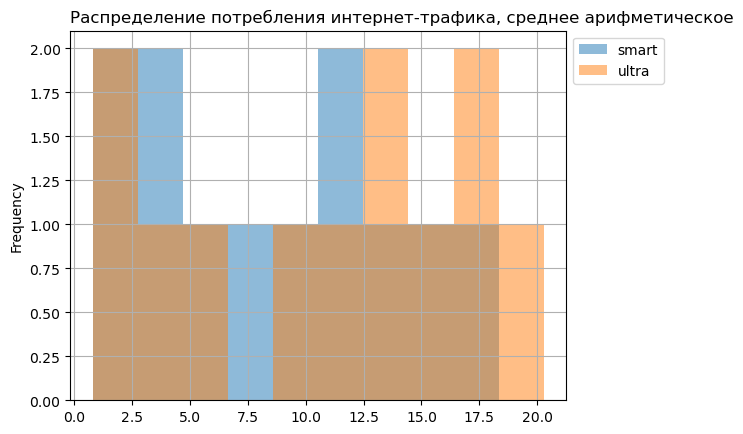

In [47]:
analytics_hist(df_internet_smart, df_internet_ultra, 'Распределение потребления интернет-трафика, среднее арифметическое')

Похоже, что больше 20Гб требуется считанным  единицам. У пользователей "Ультры" не получается пока даже близко приблизится к лимитам тарифа.

### * стоимость услуг

[  69.87179487  136.75498575  255.48717949  307.31054131  481.05128205
  562.56125356  700.89458689  884.15954416  925.88603989 1143.21082621
 1209.12535613 1517.13675214]
[ 117.7852349   318.12080537  500.33557047  738.9261745   926.17449664
 1149.66442953 1293.62416107 1495.97315436 1562.41610738 1705.36912752
 1881.54362416 2008.38926174]


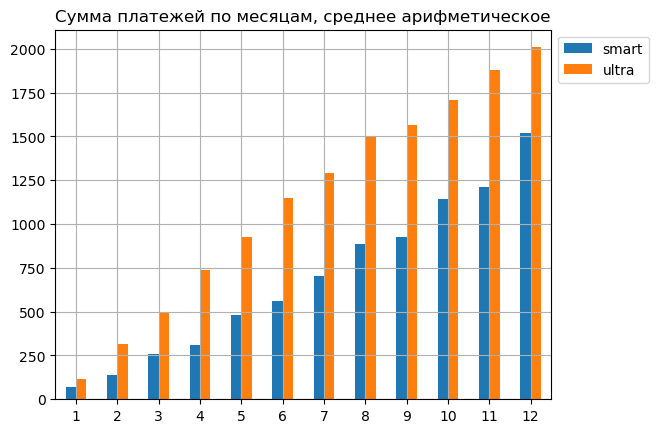

In [48]:
analytics_bar(df_money_smart, df_money_ultra, 'Сумма платежей по месяцам, среднее арифметическое')

Пользователем "Смарта" начинает не хватать включенных в пакет услуг. Им приходится пользоваться платными, и с каждым месяцем все больше. 

Странно, но пользователям "Ультры" так же пришлось доплачивать  в конце года, хотя и не так много. Это говорит о том, что есть ну очень активные потребители.

[  69.87179487  136.75498575  255.48717949  307.31054131  481.05128205
  562.56125356  700.89458689  884.15954416  925.88603989 1143.21082621
 1209.12535613 1517.13675214]
[ 117.7852349   318.12080537  500.33557047  738.9261745   926.17449664
 1149.66442953 1293.62416107 1495.97315436 1562.41610738 1705.36912752
 1881.54362416 2008.38926174]


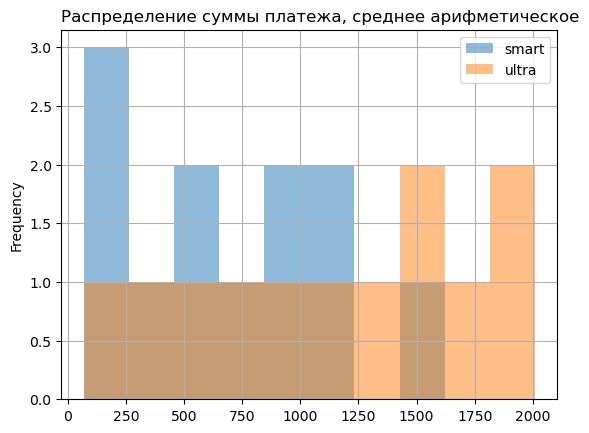

In [49]:
analytics_hist(df_money_smart, df_money_ultra, 'Распределение суммы платежа, среднее арифметическое')

Здесь мы явно видим, сколько приходится доплачивать пользователям тарифов. Для "Ультры" это в пределах 50 рублей. А вот некоторые пользователи тарифа "Смарт" переплачивают в два, а то и в три раза.

[ 252.58598101  377.30571511  582.01095643  549.81286986  744.79157406
  787.96277728  824.18213157  898.10362601  835.4935572   921.2507653
  855.72103679 1058.13275083]
[ 466.11801898  729.22151116  879.42888109  976.49479382 1062.76958253
 1041.94945675 1093.05684353  999.40044152  879.5135718   861.56953217
  741.33164044  691.51231362]


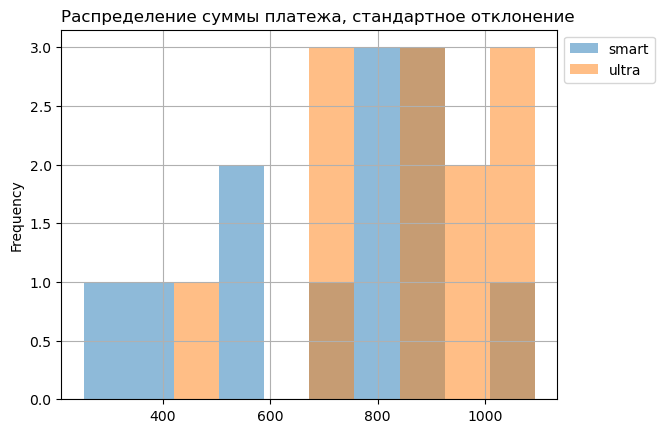

In [50]:
analytics_hist_add(df_money_smart, df_money_ultra, np.std, 'Распределение суммы платежа, стандартное отклонение')

analytics_hist_add(df_internet_smart, df_internet_ultra, np.var, 'Распределение суммы платежа, дисперсия')

Итак, мы поняли, что не смотря на среднее количество потраченных минут, СМС и потребленного интернет-трафика (которые ниже лимитов тарифа "Смарт"), часть пользователей вынуждена пользоваться платными услугами; это вызывает переплату в разы, но все равно это меньше, чем цена пакета "Ультра".

Пользователи "Ультра", в общем и целом, укладываются в предоплаченные услуги, а если нет, доплачиват немного, в районе 50-ти рублей.

## Проверка гипотез

Итак, у нас есть две таблицы `df_money_ultra` и `df_money_smart` с выручкой пользователей помесячно. Добавим стобец `total`, чтобы получить выручку за год для каждого пользователя.

In [51]:
df_money_ultra['total'] = df_money_ultra.iloc[:,2:14].sum(axis=1)
df_money_ultra.tail(5)

,tariff,user_id,1,2,3,4,5,6,7,8,9,10,11,12,total
495,ultra,1476,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,17550.0
496,ultra,1485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0
497,ultra,1491,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,17550.0
498,ultra,1493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,3750.0,5700.0
499,ultra,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2400.0,1950.0,3300.0,1950.0,11550.0


In [52]:
df_money_smart['total'] = df_money_smart.iloc[:,2:14].sum(axis=1)
df_money_smart.tail(5)

,tariff,user_id,1,2,3,4,5,6,7,8,9,10,11,12,total
346,smart,1494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,953.0,1150.0,1150.0,1150.0,4953.0
347,smart,1496,550.0,3432.0,2721.0,1813.0,2350.0,1715.0,2596.0,2231.0,2950.0,3150.0,3036.0,1807.0,28351.0
348,smart,1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,1685.0,2785.0
349,smart,1498,0.0,0.0,0.0,0.0,0.0,0.0,550.0,2386.0,1950.0,1750.0,0.0,0.0,6636.0
350,smart,1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,1150.0,1513.0,598.0,3811.0


Смотрим выбросы: строим гисторамму  и смотрим распределения.

In [53]:
df_money_smart.groupby('tariff')['total'].describe().round()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,351.0,8193.0,5412.0,550.0,4188.0,7250.0,11199.0,28351.0


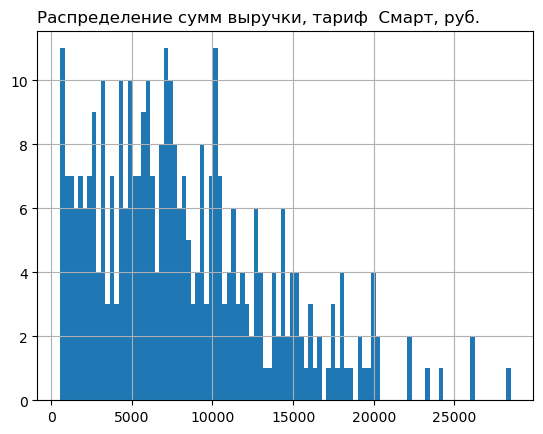

In [54]:
df_money_smart.total.hist(bins=100, range=(550,28500))
plt.title('Распределение сумм выручки, тариф  Смарт, руб.', loc = 'left')
plt.show()

График показывает, что потребление платных услуг в тарифе "Смарт" - обычное явление. 

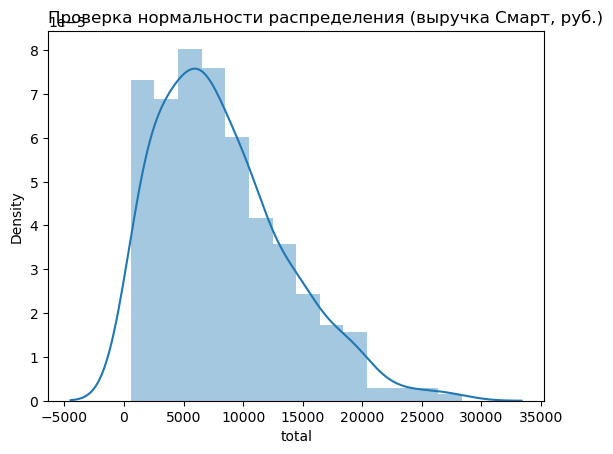

In [55]:
sns.distplot(df_money_smart['total'])    # проверяем распределение на нормальность
plt.title('Проверка нормальности распределения (выручка Смарт, руб.)', loc = 'left')
plt.show()

In [56]:
df_money_ultra.groupby('tariff')['total'].describe().round()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
ultra,149.0,13698.0,6912.0,1950.0,7800.0,13650.0,19500.0,32400.0


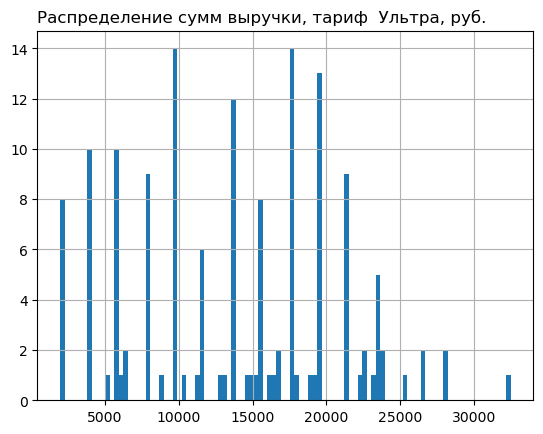

In [57]:
df_money_ultra.total.hist(bins=100, range=(1950,32500))
plt.title('Распределение сумм выручки, тариф  Ультра, руб.', loc = 'left')
plt.show()

Мы видим пики, котрые кратны размеру абон. платы, что говорит о том, что предоплаченных услуг тарифа "Ультра" практически всегда достаточно.

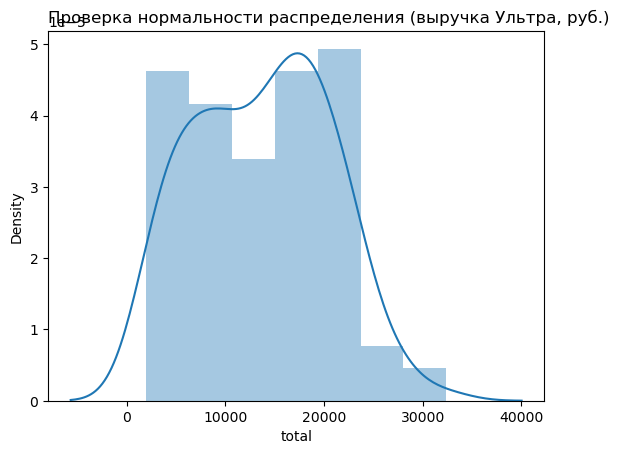

In [58]:
sns.distplot(df_money_ultra['total'])
plt.title('Проверка нормальности распределения (выручка Ультра, руб.)', loc = 'left')
plt.show()

In [59]:
df_money_ultra = df_money_ultra.query('total <= 24000')
df_money_ultra.shape

(143, 15)

### * проверка первой гипотезы

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова}\\
   H_1 :\text{средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$ 

Посчитаем p-value, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.

У нас разные по размеру выборки (пользователей тарифа "Смарт" в два раза больше, чем пользователей тарифа "Ультра").
Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод `st.stats.ttest_ind`, так же мы будем использовать параметр `equal_var=False`, т.к. есть сомнения по поводу нормального распределения дисперсий (если судить по гистограмме п.4.4).

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [60]:
alpha = .05 # критический уровень статистической значимости

results = st.stats.ttest_ind(df_money_ultra['total'], df_money_smart['total'], equal_var=False)

print('p-значение: ', results.pvalue)    # тест двухсторонний
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  3.497011826267894e-14
Отвергаем нулевую гипотезу


**Вывод:** 

p-value получилось меньше выбранного уровня 𝛼=0.05. Отвергаем нулевую гипотезу, т.к. средние выручки пользователей тарифов «Ультра» и «Смарт» различаются.

_______
Проверим еще одну теорию.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова}\\
   H_1 :\text{средняя выручка пользователей тарифа «Ультра» больше, чем средняя выручка пользователей тарифа «Смарт»}
 \end{cases}
\end{equation*}$

In [61]:
alpha = .05 # критический уровень статистической значимости

results = st.stats.ttest_ind(df_money_ultra['total'], df_money_smart['total'], equal_var=False)

# тест односторонний: p-value будет в два раза меньше
print('p-значение: ', results.pvalue / 2)

# тест односторонний влево:
# отвергаем гипотезу только если выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue / 2 < alpha) and (df_money_ultra['total'].mean() > df_money_smart['total'].mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.748505913133947e-14
Отвергаем нулевую гипотезу


**Вывод:** 

p-value получилось меньше выбранного уровня 𝛼=0.05. Отвергаем нулевую гипотезу, средняя выручка пользователей тарифа «Ультра» больше, чем средняя выручка пользователей тарифа «Смарт».

### * проверка второй гипотезы

####  выручка по локациям

Сделаем отдельную таблицу `users_dict_city`, которая будет содержать только id пользователей и город их проживаня и объединим ее с таблицей `df_money`.

In [62]:
users_dict_city = users[['user_id','city']]

df_money_city = df_money.merge(users_dict_city, on='user_id', how='left')
df_money_city.tail(3)

,tariff,user_id,1,2,3,4,5,6,7,8,9,10,11,12,city
497,ultra,1491,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,Челябинск
498,ultra,1493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,3750.0,Красноярск
499,ultra,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2400.0,1950.0,3300.0,1950.0,Иркутск


In [63]:
df_money_city['total'] = df_money_city.iloc[:,2:14].sum(axis=1)    # добавляем столбец total

In [64]:
df_money_moscow = df_money_city[df_money_city['city'] == 'Москва']     # выручка от пользователей Москвы
df_money_moscow.tail(3)

,tariff,user_id,1,2,3,4,5,6,7,8,9,10,11,12,city,total
484,ultra,1453,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,Москва,23400.0
487,ultra,1461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,Москва,3900.0
495,ultra,1476,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,Москва,17550.0


In [65]:
df_money_other = df_money_city[df_money_city['city'] != 'Москва']    # выручка от пользователей других городов
df_money_other.tail(3)

,tariff,user_id,1,2,3,4,5,6,7,8,9,10,11,12,city,total
497,ultra,1491,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,Челябинск,17550.0
498,ultra,1493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,3750.0,Красноярск,5700.0
499,ultra,1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2400.0,1950.0,3300.0,1950.0,Иркутск,11550.0


Смотрим выбросы: строим гисторамму  и смотрим распределения.

In [66]:
df_money_moscow.groupby('city')['total'].describe().round()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Москва,99.0,9546.0,6632.0,550.0,4378.0,7800.0,13776.0,28050.0


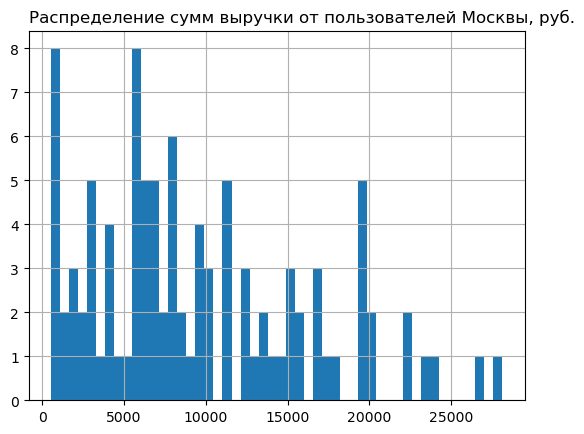

In [67]:
df_money_moscow.total.hist(bins=50, range=(550,28100))
plt.title('Распределение сумм выручки от пользователей Москвы, руб.', loc = 'left')
plt.show()

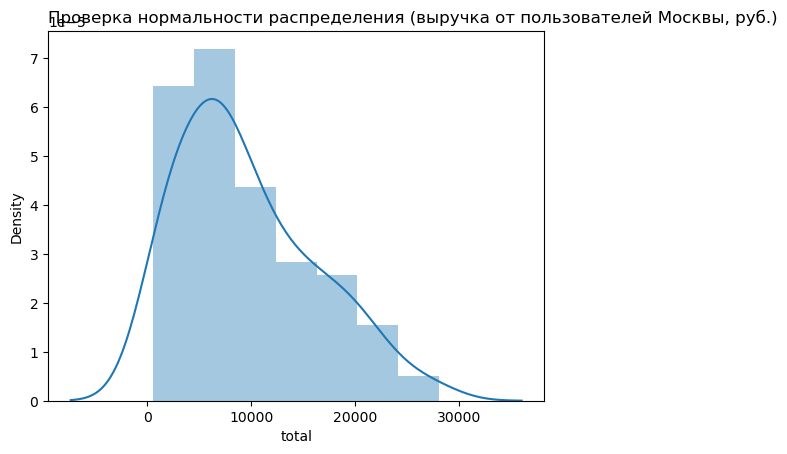

In [68]:
sns.distplot(df_money_moscow['total'])
plt.title('Проверка нормальности распределения (выручка от пользователей Москвы, руб.)', loc = 'left')
plt.show()

Как видно на гистограммах, распределение не нормальное. Так же видим два пика (это абонентская плата по тарифом, остальное - дополнительные платные услуги. Пользователей тарифа "Смарт" больше.

In [69]:
df_money_other.describe().round()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,total
count,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0,401.0
mean,1248.0,75.0,197.0,327.0,435.0,623.0,744.0,892.0,1082.0,1128.0,1322.0,1400.0,1680.0,9905.0
std,146.0,296.0,522.0,686.0,718.0,874.0,916.0,967.0,980.0,889.0,943.0,891.0,1001.0,6359.0
min,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0
25%,1122.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,598.0,950.0,4947.0
50%,1243.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0,950.0,950.0,1350.0,1411.0,1798.0,8839.0
75%,1375.0,0.0,0.0,0.0,550.0,1150.0,1624.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,14134.0
max,1499.0,2350.0,3432.0,2721.0,3000.0,3900.0,4473.0,4200.0,4650.0,3759.0,4800.0,5680.0,6770.0,32400.0


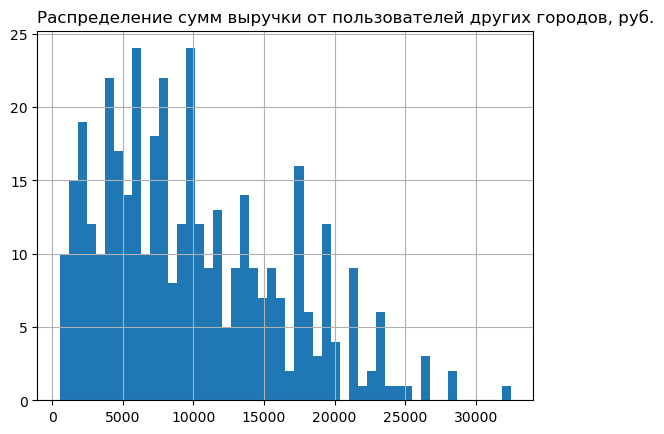

In [70]:
df_money_other.total.hist(bins=50, range=(550,32500))
plt.title('Распределение сумм выручки от пользователей других городов, руб.', loc = 'left')
plt.show()

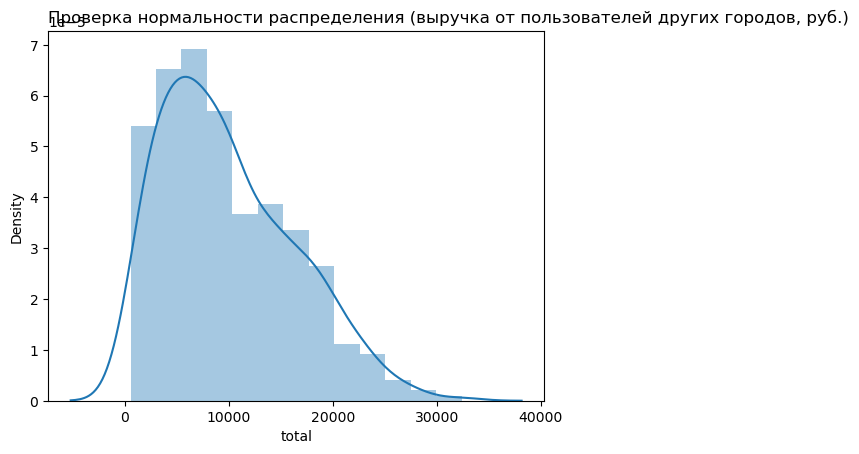

In [71]:
sns.distplot(df_money_other['total'])
plt.title('Проверка нормальности распределения (выручка от пользователей других городов, руб.)', loc = 'left')
plt.show()

Здесь картина такая же, но видно, что дополнительных платных услуг  пользователи других городов потребляют больше, чем москвичи.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{средняя выручка пользователей из Москвы и регионов одинакова}\\
   H_1 :\text{средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$ 

Посчитаем p-value, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.

У нас разные по размеру выборки (пользователей других городов в четыре раза больше, чем пользователей Москвы).
Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод `st.stats.ttest_ind`, так же мы будем использовать параметр `equal_var=False`, т.к. есть сомнения по поводу нормального распределения дисперсий.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [72]:
alpha = .05   # критический уровень статистической значимости    
results = st.stats.ttest_ind(df_money_moscow['total'], df_money_other['total'], equal_var=False)

print('p-значение: ', results.pvalue)    # тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.6273901360626399
Не получилось отвергнуть нулевую гипотезу


**Вывод:** 

p-value получилось больше выбранного уровня 𝛼=0.05. Отвергнуть нулевую гипотезу не получилось, средняя выручка пользователей из Москвы и регионов одинакова.

## Вывод

Исследование проводилось на выборке из пятисот пользователей тарифов "Ультра" и "Смарт" как Москвы, так и других городов.

При этом, пользователей из Москвы было меньше, а среди выбранного пользователями тарифа преобладал "Смарт".

Было выявлено, что в среднем, пользователи тарифов укладываются в лимиты. Но в частных случаях, есть потребность в использовании дополнительных платных услуг; для Ультры переплаты составляют 50-100 рублей в месяц, в то время как некоторые пользователи тарифа "Смарт" могут тратить по 2-3 эквивалента абонентской платы в месяц.

В ходе анализа нужно было подтвердить следующие гипотезы:

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

В первом случае мы опровергли нулевую гипотезу о равенстве средней выручки тарифов и не смогли опровергнуть гипотезу о том, что средняя выручка тарифа "Ультра" больше, чем средняя выручка тарифа "Смарт".

Во втором случае нулевая гипотеза о равенстве средней выручке пользователей из Москвы и пользователей из других городов отвергнута не была. 
